In [1]:
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')
import numpy as np
import pandas as pd
import xarray as xr

import wandb
import xgboost as xgb
import re

from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

random_state = 69
np.random.state = random_state
np.random.seed = random_state

/Users/thomasdodd/opt/anaconda3/envs/omphalos/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 3D Comparison of XGBoost Models Trained for Different Numbers of Epochs

In [2]:
# Define all the attributes we have varied in .yaml file
attribute_names = ["Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)","Cl-"]

In [3]:
y_norm = 96.2359084
x_norms = [0.0199996777771118,0.0199998101672167,0.019999719657439,0.019999945896381,0.0199997455006281,0.0199994907051103,0.0199990220873342,0.0199997402413945]

In [4]:
# Get all possible pairs of attributes
attribute_pairs_ls = [(a, b) for idx, a in enumerate(attribute_names) for b in attribute_names[idx + 1:]]
print(attribute_pairs_ls)
# Get number of all possible pairs of attributes
attribute_pairs_len = len(attribute_pairs_ls)
print(attribute_pairs_len)

[('Al+++', 'Ca++'), ('Al+++', 'Fe++'), ('Al+++', 'K+'), ('Al+++', 'Na+'), ('Al+++', 'Mg++'), ('Al+++', 'SiO2(aq)'), ('Al+++', 'Cl-'), ('Ca++', 'Fe++'), ('Ca++', 'K+'), ('Ca++', 'Na+'), ('Ca++', 'Mg++'), ('Ca++', 'SiO2(aq)'), ('Ca++', 'Cl-'), ('Fe++', 'K+'), ('Fe++', 'Na+'), ('Fe++', 'Mg++'), ('Fe++', 'SiO2(aq)'), ('Fe++', 'Cl-'), ('K+', 'Na+'), ('K+', 'Mg++'), ('K+', 'SiO2(aq)'), ('K+', 'Cl-'), ('Na+', 'Mg++'), ('Na+', 'SiO2(aq)'), ('Na+', 'Cl-'), ('Mg++', 'SiO2(aq)'), ('Mg++', 'Cl-'), ('SiO2(aq)', 'Cl-')]
28


In [5]:
# Max values for parameters in yaml
yamlvariable_range_upper = 2.0E-2
# Number of samples we'd like to get the model to predict on
samples = 100
# The controlled values in the base .in file
incontrolled_val = 1.00E-10

In [6]:
# The (ab)normalization functions
def NormalizeData(data, upper):
    return data / upper
def AbNormalizeData(data, upper):
    return data * upper
def ScaleData(data, scale_factor):
    return data * scale_factor

In [7]:
def xyz_mesh_getter_narrowed(upper, samples, attrib_names, attrib_pair, var_controlled, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms):
    x_attrib_name = attrib_pair[0]
    y_attrib_name = attrib_pair[1]

    x_attrib_name_upper = 0
    x_attrib_name_lower = 0

    y_attrib_name_upper = 0
    y_attrib_name_lower = 0

    for _,__,___ in zip(attrib_names, attribute_names_uppers, attribute_names_lowers):
        if x_attrib_name == _:
            x_attrib_name_upper = __
            x_attrib_name_lower = ___
        elif y_attrib_name == _:
            y_attrib_name_upper = __
            y_attrib_name_lower = ___
    
    x_normalising_value = 0
    y_normalising_value = 0

    for _,__ in zip(attrib_names, x_norms):
        if x_attrib_name == _:
            x_normalising_value = __
        elif y_attrib_name == _:
            y_normalising_value = __

    xpred = np.linspace(x_attrib_name_lower, x_attrib_name_upper, samples)
    xpred = xpred.reshape(-1,1)
    xpred_norm = NormalizeData(xpred, x_normalising_value)
    xpred_scaled = ScaleData(xpred, 1000)

    ypred = np.linspace(y_attrib_name_lower, y_attrib_name_upper, samples)
    ypred = ypred.reshape(-1,1)
    ypred_norm = NormalizeData(ypred, y_normalising_value)
    ypred_scaled = ScaleData(xpred, 1000)

    X,Y = np.meshgrid(xpred,ypred)
    X_norm,Y_norm = np.meshgrid(xpred_norm,ypred_norm)
    X_scaled, Y_scaled = np.meshgrid(xpred_scaled,ypred_scaled)

    Z = np.empty_like(X)
    Z_norm = np.empty_like(X)

    row = 0
    for X_row_arr,Y_row_arr in zip(X_norm,Y_norm):
        column = 0
        for X_scalar,Y_scalar in zip(X_row_arr,Y_row_arr):
            XYScalars = [X_scalar,Y_scalar]
            end_attrib_list = []

            for _ in attrib_names:
                if x_attrib_name == _:
                    end_attrib_list.append(XYScalars[0])
                elif y_attrib_name == _:
                    end_attrib_list.append(XYScalars[1])
                else:
                    end_attrib_list.append(var_controlled)

            zpred_norm = bst.predict(xgb.DMatrix(np.array([end_attrib_list])))
            zpred = AbNormalizeData(zpred_norm, y_norm)
            Z[row,column] = zpred
            Z_norm[row,column] = zpred_norm
            column += 1
        row += 1
    return X_scaled, Y_scaled, Z

In [8]:
attribute_names_uppers = [1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2]
attribute_names_lowers = [0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2]

In [ ]:
# Set the attribute pair
attribute_pair = attribute_pairs_ls[5]
# Assign the two string items in the pair to a variable each
x_attrib_name = attribute_pair[0]
y_attrib_name = attribute_pair[1]

fig = plt.figure(figsize=(15,15))
fig.tight_layout(h_pad=-75, w_pad=10, pad=5)
ax1 = fig.add_subplot(1,4,1, projection='3d')
ax2 = fig.add_subplot(1,4,2, projection='3d')
ax3 = fig.add_subplot(1,4,3, projection='3d')
ax4 = fig.add_subplot(1,4,4, projection='3d')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-300.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax1.set_zlim(0, 5)
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax1.set_xlabel(f'[{x_attrib_name}]')
ax1.set_ylabel(f'[{y_attrib_name}]')
ax1.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-3000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax2.set_zlim(0, 5)
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax2.set_xlabel(f'[{x_attrib_name}]')
ax2.set_ylabel(f'[{y_attrib_name}]')
ax2.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-30000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax3.set_zlim(0, 5)
ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax3.set_xlabel(f'[{x_attrib_name}]')
ax3.set_ylabel(f'[{y_attrib_name}]')
ax3.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-300000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax4.set_zlim(0, 5)
ax4.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax4.set_xlabel(f'[{x_attrib_name}]')
ax4.set_ylabel(f'[{y_attrib_name}]')
ax4.set_zlabel('Carbonates (%)')

In [ ]:
# Set the attribute pair
attribute_pair = attribute_pairs_ls[5]
# Assign the two string items in the pair to a variable each
x_attrib_name = attribute_pair[0]
y_attrib_name = attribute_pair[1]

fig = plt.figure(figsize=(30,30))
fig.tight_layout(h_pad=-75, w_pad=10, pad=5)
ax1 = fig.add_subplot(1,4,1, projection='3d')
ax2 = fig.add_subplot(1,4,2, projection='3d')
ax3 = fig.add_subplot(1,4,3, projection='3d')
ax4 = fig.add_subplot(1,4,4, projection='3d')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-300.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax1.set_title("Undertrained Model\nEpochs = 300")
ax1.set_zlim(0, 5)
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax1.set_xlabel(f'[{x_attrib_name}]')
ax1.set_ylabel(f'[{y_attrib_name}]')
ax1.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-3000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax2.set_title("Well-Trained Model\nEpochs = 3,000")
ax2.set_zlim(0, 5)
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax2.set_xlabel(f'[{x_attrib_name}]')
ax2.set_ylabel(f'[{y_attrib_name}]')
ax2.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-30000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax3.set_title("Overtrained Model\nEpochs = 30,000")
ax3.set_zlim(0, 5)
ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax3.set_xlabel(f'[{x_attrib_name}]')
ax3.set_ylabel(f'[{y_attrib_name}]')
ax3.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-300000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax4.set_zlim(0, 5)
ax4.set_title("V. Overtrained Model\nEpochs = 300,000")
ax4.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax4.set_xlabel(f'[{x_attrib_name}]') #mmol kg^-1
ax4.set_ylabel(f'[{y_attrib_name}]')
ax4.set_zlabel('Carbonates (%)')

Text(0.5, 0, 'Carbonates (%)')

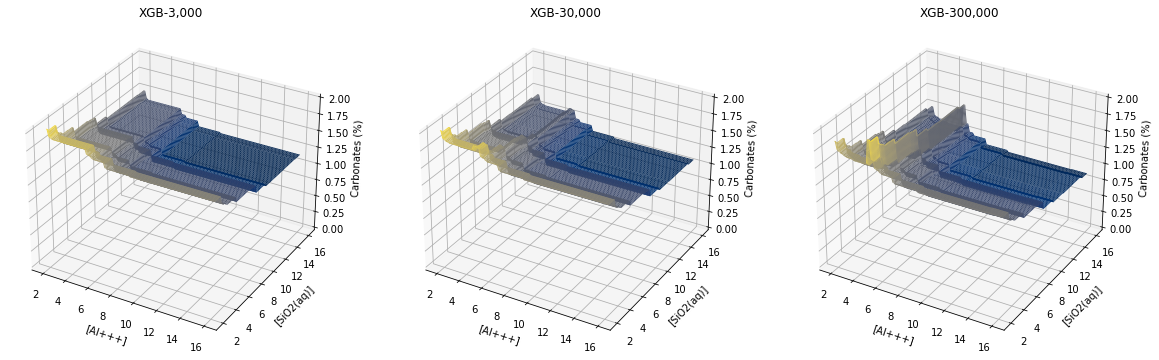

In [9]:
# Set the attribute pair
attribute_pair = attribute_pairs_ls[5]
# Assign the two string items in the pair to a variable each
x_attrib_name = attribute_pair[0]
y_attrib_name = attribute_pair[1]

fig = plt.figure(figsize=(20,30))
fig.tight_layout(h_pad=-75, w_pad=10, pad=5)
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-3000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax1.set_title("XGB-3,000")
ax1.set_zlim(0, 2)
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax1.set_xlabel(f'[{x_attrib_name}]')
ax1.set_ylabel(f'[{y_attrib_name}]')
ax1.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-30000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax2.set_title("XGB-30,000")
ax2.set_zlim(0, 2)
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax2.set_xlabel(f'[{x_attrib_name}]')
ax2.set_ylabel(f'[{y_attrib_name}]')
ax2.set_zlabel('Carbonates (%)')

# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-300000.json')
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
# Plot onto a set of axes
ax3.set_title("XGB-300,000")
ax3.set_zlim(0, 2)
ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax3.set_xlabel(f'[{x_attrib_name}]')
ax3.set_ylabel(f'[{y_attrib_name}]')
ax3.set_zlabel('Carbonates (%)')